# Proyecto Final: Modelo Predictivo de Burnout con Deep Neural Network


## 1. IMPORTACIÓN DE DEPENDENCIAS

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, mean_squared_error, r2_score, mean_absolute_error
)
from imblearn.over_sampling import SMOTE
from collections import Counter
import pickle
import warnings

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

warnings.filterwarnings('ignore')
tf.random.set_seed(42)
np.random.seed(42)

# Configuraciones
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

print(f"GPU disponible: {len(tf.config.list_physical_devices('GPU')) > 0}")

GPU disponible: True


## 2. CARGA Y PREPROCESAMIENTO DEL DATASET

In [21]:
try:
    dataset = pd.read_csv('Proyecto_final.csv', sep=';')
    print(f"\n✓ Dataset cargado: {dataset.shape[0]} filas x {dataset.shape[1]} columnas")
except FileNotFoundError:
    print("Error: El archivo 'Proyecto_final.csv' no se encontró.")
    raise

# Información básica
print(f"\n{'='*80}")
print("INFORMACIÓN DEL DATASET")
print(f"{'='*80}")
dataset.info()


✓ Dataset cargado: 103 filas x 145 columnas

INFORMACIÓN DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Columns: 145 entries, Id to GBC_Puntaje
dtypes: float64(4), int64(136), object(5)
memory usage: 116.8+ KB


In [22]:
# Eliminar columnas innecesarias
columns_to_drop = [
    'GBC_Puntaje', 'LGS_Puntaje', 'PERMA_Puntaje', 'Id', 'Formulario', 
    'Horadeinicio', 'HoradefinalizaciÃ³n', 'HoraRealizacion', 'TiempoRequerido', 'CI',
    'Diplomatura', 'Maestria', 'Doctorado', 'AE_MBI', 'Nivel_AE_MBI', 
    'RP_MBI', 'Nivel_RP_MBI', 'DSP_MBI', 'Nivel_DSP_MBI'
]
dataset_cleaned = dataset.drop(columns=[col for col in columns_to_drop if col in dataset.columns])

# Tratamiento de valores especiales y nulos
dataset_cleaned = dataset_cleaned.replace(999, np.nan)
null_counts = dataset_cleaned.isnull().sum(axis=1)
rows_to_drop = null_counts[null_counts > dataset_cleaned.shape[1] * 0.5].index
dataset_cleaned = dataset_cleaned.drop(rows_to_drop)

# Imputación de nulos con mediana
numeric_cols = dataset_cleaned.select_dtypes(include=np.number).columns
for col in numeric_cols:
    if dataset_cleaned[col].isnull().sum() > 0:
        dataset_cleaned[col].fillna(dataset_cleaned[col].median(), inplace=True)

# Conversión de variables discretas a categóricas
categorical_threshold = 20
for col in dataset_cleaned.select_dtypes(include=['number']).columns:
    if dataset_cleaned[col].nunique() < categorical_threshold:
        dataset_cleaned[col] = dataset_cleaned[col].astype('category')

# Asegurar que Jerarquia sea numérica
if 'Jerarquia' in dataset_cleaned.columns:
    dataset_cleaned['Jerarquia'] = pd.to_numeric(dataset_cleaned['Jerarquia'], errors='coerce')
    if dataset_cleaned['Jerarquia'].isnull().sum() > 0:
        dataset_cleaned['Jerarquia'].fillna(dataset_cleaned['Jerarquia'].median(), inplace=True)
    dataset_cleaned['Jerarquia'] = dataset_cleaned['Jerarquia'].astype('category')

# Transformación logarítmica para asimetría
numeric_cols = dataset_cleaned.select_dtypes(include=[np.number]).columns
skewness_df = dataset_cleaned[numeric_cols].skew().sort_values(ascending=False)
skewed_cols = skewness_df[skewness_df > 1].index.tolist()
skewed_cols = [col for col in skewed_cols if col not in ['MBI_Burnout', 'MBI_RiesgoBurnout1']]

for col in skewed_cols:
    dataset_cleaned[f'{col}_log'] = np.log1p(dataset_cleaned[col])
    dataset_cleaned = dataset_cleaned.drop(col, axis=1)

print(f"✓ Preprocesamiento completado: {dataset_cleaned.shape}")

✓ Preprocesamiento completado: (102, 127)


## 3. PREPARACIÓN DE DATOS

In [23]:
target_cols = ['MBI_Burnout', 'MBI_RiesgoBurnout1']

# Clasificación
y_classification = dataset_cleaned['MBI_Burnout'].copy().values
X = dataset_cleaned.drop(columns=target_cols)

# Regresión
y_regression = dataset_cleaned['MBI_RiesgoBurnout1'].copy().values

# Codificación One-Hot
X_encoded = pd.get_dummies(X, drop_first=True)
feature_names = X_encoded.columns.tolist()

print(f"\n✓ Features después de encoding: {X_encoded.shape}")
print(f"✓ Distribución de clases: {Counter(y_classification)}")


✓ Features después de encoding: (102, 628)
✓ Distribución de clases: Counter({0.0: 82, 1.0: 20})


## 4. ARQUITECTURA DE LA RED NEURONAL

In [24]:
def create_classification_model(input_dim, learning_rate=0.001):
    """
    DNN para clasificación binaria optimizada para datasets pequeños
    """
    model = Sequential([
        Input(shape=(input_dim,)),
        
        # Primera capa: más neuronas para capturar patrones
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),
        
        # Segunda capa
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Tercera capa
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Cuarta capa
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        
        # Capa de salida
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), 
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    
    return model

In [25]:
def create_regression_model(input_dim, learning_rate=0.001):
    """
    DNN para regresión optimizada para datasets pequeños
    """
    model = Sequential([
        Input(shape=(input_dim,)),
        
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    
    return model

## 5. K-FOLD CROSS VALIDATION - CLASIFICACIÓN

In [26]:
print(f"\n{'='*80}")
print("ENTRENAMIENTO CON K-FOLD CROSS VALIDATION - CLASIFICACIÓN")
print(f"{'='*80}")

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Métricas por fold
fold_metrics_clf = {
    'accuracy': [], 'precision': [], 'recall': [], 
    'f1': [], 'auc': [], 'loss': []
}

# Historiales de entrenamiento
fold_histories_clf = []

# Modelos entrenados
trained_models_clf = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_encoded, y_classification), 1):
    print(f"\n{'-'*80}")
    print(f"FOLD {fold}/{n_splits}")
    print(f"{'-'*78}")
    
    # Split de datos
    X_train_fold = X_encoded.iloc[train_idx].values
    y_train_fold = y_classification[train_idx]
    X_val_fold = X_encoded.iloc[val_idx].values
    y_val_fold = y_classification[val_idx]
    
    print(f"Train: {len(train_idx)} | Val: {len(val_idx)}")
    print(f"Distribución train: {Counter(y_train_fold)}")
    
    # Aplicar SMOTE solo en train
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)
    print(f"Después de SMOTE: {Counter(y_train_resampled)}")
    
    # Escalar
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_val_scaled = scaler.transform(X_val_fold)
    
    # Crear y entrenar modelo
    model = create_classification_model(X_train_scaled.shape[1])
    
    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=0
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=0
    )
    
    # Entrenar
    history = model.fit(
        X_train_scaled, y_train_resampled,
        validation_data=(X_val_scaled, y_val_fold),
        epochs=400,
        batch_size=16,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )
    
    fold_histories_clf.append(history)
    
    # Evaluar
    y_pred_proba = model.predict(X_val_scaled, verbose=0).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calcular métricas
    acc = accuracy_score(y_val_fold, y_pred)
    prec = precision_score(y_val_fold, y_pred, zero_division=0)
    rec = recall_score(y_val_fold, y_pred, zero_division=0)
    f1 = f1_score(y_val_fold, y_pred, zero_division=0)
    auc_score = roc_auc_score(y_val_fold, y_pred_proba)
    val_loss = history.history['val_loss'][-1]
    
    fold_metrics_clf['accuracy'].append(acc)
    fold_metrics_clf['precision'].append(prec)
    fold_metrics_clf['recall'].append(rec)
    fold_metrics_clf['f1'].append(f1)
    fold_metrics_clf['auc'].append(auc_score)
    fold_metrics_clf['loss'].append(val_loss)
    
    print(f"\n✓ Accuracy: {acc:.4f}")
    print(f"✓ Precision: {prec:.4f}")
    print(f"✓ Recall: {rec:.4f}")
    print(f"✓ F1-Score: {f1:.4f}")
    print(f"✓ AUC-ROC: {auc_score:.4f}")
    print(f"✓ Val Loss: {val_loss:.4f}")
    print(f"✓ Epochs entrenadas: {len(history.history['loss'])}")
    
    trained_models_clf.append({
        'model': model,
        'scaler': scaler,
        'metrics': {
            'accuracy': acc, 'precision': prec, 'recall': rec,
            'f1': f1, 'auc': auc_score
        }
    })


ENTRENAMIENTO CON K-FOLD CROSS VALIDATION - CLASIFICACIÓN

--------------------------------------------------------------------------------
FOLD 1/5
------------------------------------------------------------------------------


Train: 81 | Val: 21
Distribución train: Counter({0.0: 65, 1.0: 16})
Después de SMOTE: Counter({np.float64(0.0): 65, np.float64(1.0): 65})

✓ Accuracy: 0.9048
✓ Precision: 0.6667
✓ Recall: 1.0000
✓ F1-Score: 0.8000
✓ AUC-ROC: 0.9706
✓ Val Loss: 0.6723
✓ Epochs entrenadas: 109

--------------------------------------------------------------------------------
FOLD 2/5
------------------------------------------------------------------------------
Train: 81 | Val: 21
Distribución train: Counter({0.0: 65, 1.0: 16})
Después de SMOTE: Counter({np.float64(0.0): 65, np.float64(1.0): 65})

✓ Accuracy: 0.8571
✓ Precision: 1.0000
✓ Recall: 0.2500
✓ F1-Score: 0.4000
✓ AUC-ROC: 0.7647
✓ Val Loss: 1.0487
✓ Epochs entrenadas: 54

--------------------------------------------------------------------------------
FOLD 3/5
------------------------------------------------------------------------------
Train: 82 | Val: 20
Distribución train: Counter({0.0: 66, 1.0: 16})
Después de SMOTE: Counter({np.float64(0.0

In [27]:
# Resumen de resultados
print(f"\n{'='*80}")
print("RESULTADOS PROMEDIO K-FOLD CROSS VALIDATION - CLASIFICACIÓN")
print(f"{'='*80}")

for metric_name, values in fold_metrics_clf.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric_name.upper():.<20} {mean_val:.4f} ± {std_val:.4f}")

# Seleccionar mejor modelo (por F1-Score)
best_fold_idx = np.argmax(fold_metrics_clf['f1'])
best_model_clf = trained_models_clf[best_fold_idx]
print(f"\n✓ Mejor modelo: Fold {best_fold_idx + 1} (F1={fold_metrics_clf['f1'][best_fold_idx]:.4f})")


RESULTADOS PROMEDIO K-FOLD CROSS VALIDATION - CLASIFICACIÓN
ACCURACY............ 0.8324 ± 0.0762
PRECISION........... 0.5833 ± 0.4014
RECALL.............. 0.4000 ± 0.3391
F1.................. 0.4233 ± 0.2867
AUC................. 0.7533 ± 0.1962
LOSS................ 0.9775 ± 0.2083

✓ Mejor modelo: Fold 1 (F1=0.8000)


## 6. K-FOLD CROSS VALIDATION - REGRESIÓN

In [28]:
print(f"\n{'='*80}")
print("ENTRENAMIENTO CON K-FOLD CROSS VALIDATION - REGRESIÓN")
print(f"{'='*80}")

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_metrics_reg = {
    'r2': [], 'mae': [], 'rmse': [], 'mse': []
}

fold_histories_reg = []
trained_models_reg = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_encoded), 1):
    print(f"\n{'-'*80}")
    print(f"FOLD {fold}/{n_splits}")
    print(f"{'-'*78}")
    
    X_train_fold = X_encoded.iloc[train_idx].values
    y_train_fold = y_regression[train_idx]
    X_val_fold = X_encoded.iloc[val_idx].values
    y_val_fold = y_regression[val_idx]
    
    print(f"Train: {len(train_idx)} | Val: {len(val_idx)}")
    
    # Escalar
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_val_scaled = scaler.transform(X_val_fold)
    
    # Crear modelo
    model = create_regression_model(X_train_scaled.shape[1])
    
    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=0
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=0
    )
    
    # Entrenar
    history = model.fit(
        X_train_scaled, y_train_fold,
        validation_data=(X_val_scaled, y_val_fold),
        epochs=400,
        batch_size=16,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )
    
    fold_histories_reg.append(history)
    
    # Evaluar
    y_pred = model.predict(X_val_scaled, verbose=0).flatten()
    
    r2 = r2_score(y_val_fold, y_pred)
    mae = mean_absolute_error(y_val_fold, y_pred)
    mse = mean_squared_error(y_val_fold, y_pred)
    rmse = np.sqrt(mse)
    
    fold_metrics_reg['r2'].append(r2)
    fold_metrics_reg['mae'].append(mae)
    fold_metrics_reg['rmse'].append(rmse)
    fold_metrics_reg['mse'].append(mse)
    
    print(f"\n✓ R² Score: {r2:.4f}")
    print(f"✓ MAE: {mae:.4f}")
    print(f"✓ RMSE: {rmse:.4f}")
    print(f"✓ MSE: {mse:.4f}")
    print(f"✓ Epochs entrenadas: {len(history.history['loss'])}")
    
    trained_models_reg.append({
        'model': model,
        'scaler': scaler,
        'metrics': {'r2': r2, 'mae': mae, 'rmse': rmse}
    })


ENTRENAMIENTO CON K-FOLD CROSS VALIDATION - REGRESIÓN

--------------------------------------------------------------------------------
FOLD 1/5
------------------------------------------------------------------------------
Train: 81 | Val: 21

✓ R² Score: 0.3337
✓ MAE: 0.2858
✓ RMSE: 0.3477
✓ MSE: 0.1209
✓ Epochs entrenadas: 81

--------------------------------------------------------------------------------
FOLD 2/5
------------------------------------------------------------------------------
Train: 81 | Val: 21

✓ R² Score: -0.4481
✓ MAE: 0.4883
✓ RMSE: 0.5436
✓ MSE: 0.2955
✓ Epochs entrenadas: 31

--------------------------------------------------------------------------------
FOLD 3/5
------------------------------------------------------------------------------
Train: 82 | Val: 20

✓ R² Score: 0.1061
✓ MAE: 0.3371
✓ RMSE: 0.4094
✓ MSE: 0.1676
✓ Epochs entrenadas: 34

--------------------------------------------------------------------------------
FOLD 4/5
----------------------

In [29]:
# Resumen regresión
print(f"\n{'='*80}")
print("RESULTADOS PROMEDIO K-FOLD CROSS VALIDATION - REGRESIÓN")
print(f"{'='*80}")

for metric_name, values in fold_metrics_reg.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric_name.upper():.<20} {mean_val:.4f} ± {std_val:.4f}")

best_fold_idx_reg = np.argmax(fold_metrics_reg['r2'])
best_model_reg = trained_models_reg[best_fold_idx_reg]
print(f"\n✓ Mejor modelo: Fold {best_fold_idx_reg + 1} (R²={fold_metrics_reg['r2'][best_fold_idx_reg]:.4f})")


RESULTADOS PROMEDIO K-FOLD CROSS VALIDATION - REGRESIÓN
R2.................. -0.0083 ± 0.2870
MAE................. 0.3617 ± 0.0794
RMSE................ 0.4335 ± 0.0788
MSE................. 0.1941 ± 0.0702

✓ Mejor modelo: Fold 1 (R²=0.3337)


## 7. VISUALIZACIONES

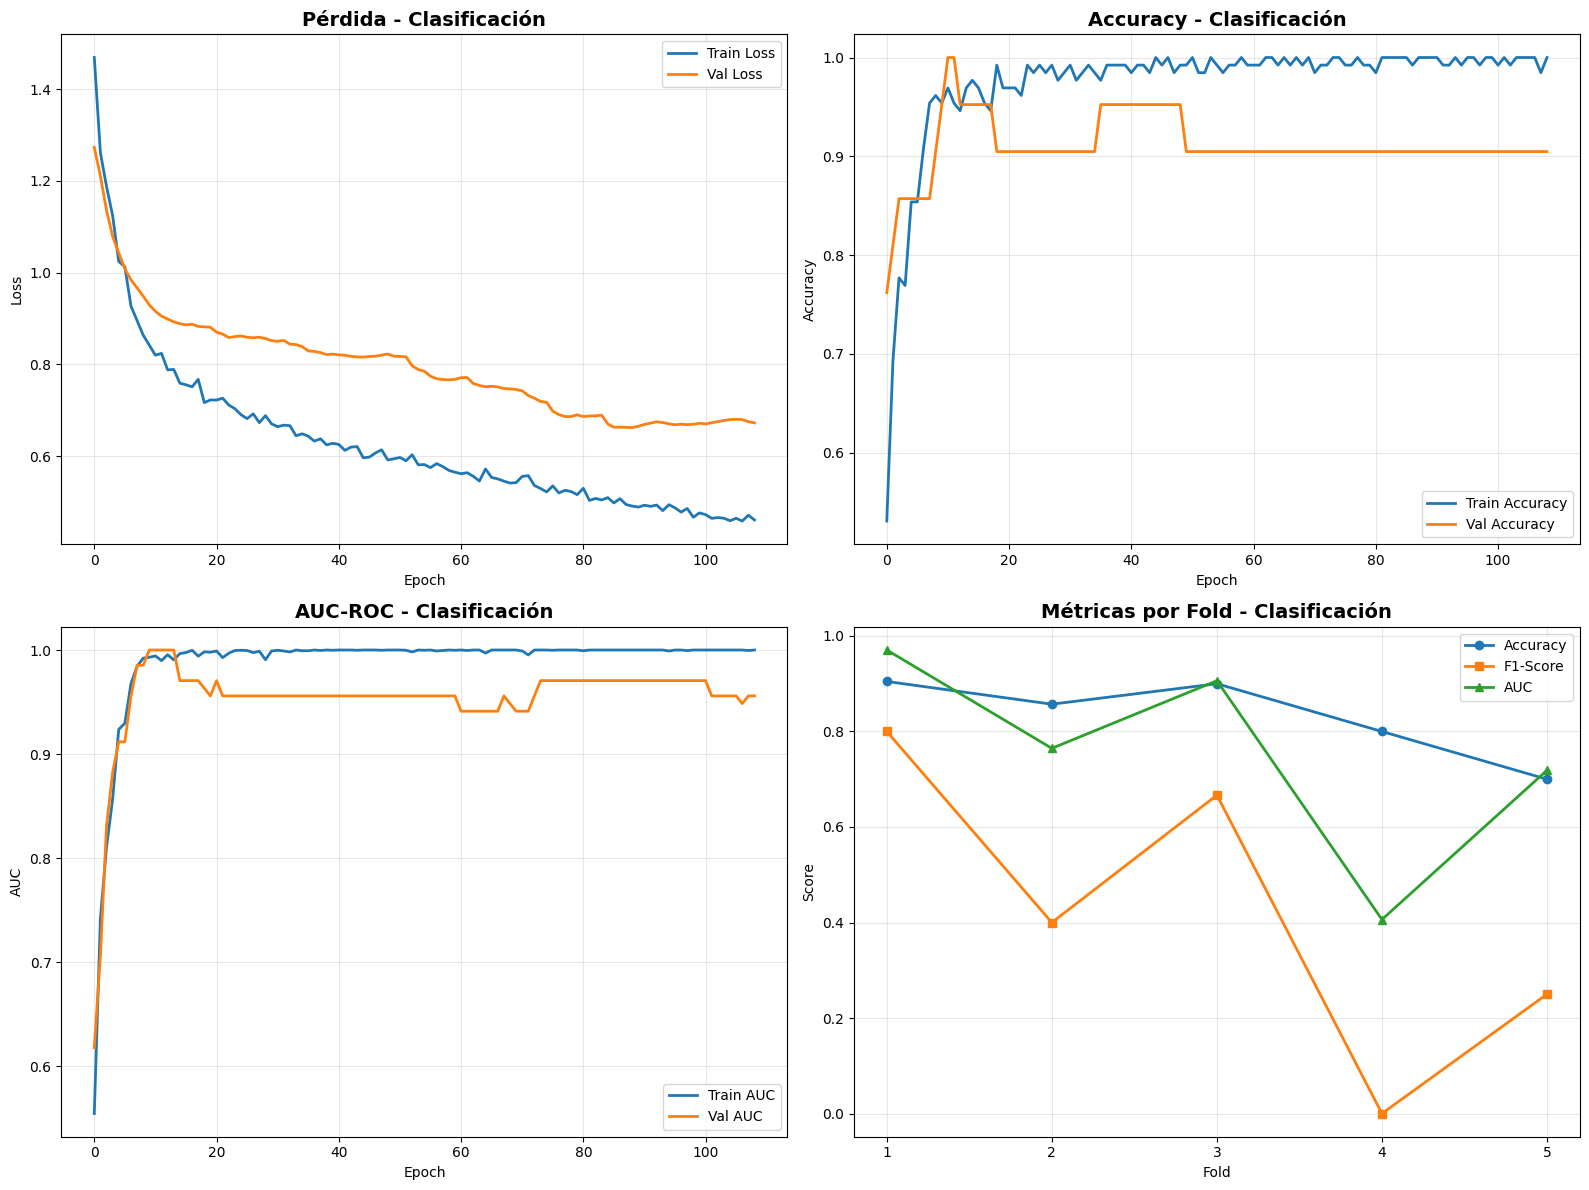

In [30]:
# Historia de entrenamiento del mejor modelo de clasificación
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

best_history_clf = fold_histories_clf[best_fold_idx]

# Loss
axes[0, 0].plot(best_history_clf.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(best_history_clf.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_title('Pérdida - Clasificación', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy
axes[0, 1].plot(best_history_clf.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 1].plot(best_history_clf.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 1].set_title('Accuracy - Clasificación', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# AUC
axes[1, 0].plot(best_history_clf.history['auc'], label='Train AUC', linewidth=2)
axes[1, 0].plot(best_history_clf.history['val_auc'], label='Val AUC', linewidth=2)
axes[1, 0].set_title('AUC-ROC - Clasificación', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Métricas por fold
fold_numbers = list(range(1, n_splits + 1))
axes[1, 1].plot(fold_numbers, fold_metrics_clf['accuracy'], marker='o', label='Accuracy', linewidth=2)
axes[1, 1].plot(fold_numbers, fold_metrics_clf['f1'], marker='s', label='F1-Score', linewidth=2)
axes[1, 1].plot(fold_numbers, fold_metrics_clf['auc'], marker='^', label='AUC', linewidth=2)
axes[1, 1].set_title('Métricas por Fold - Clasificación', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xticks(fold_numbers)

plt.tight_layout()
plt.show()

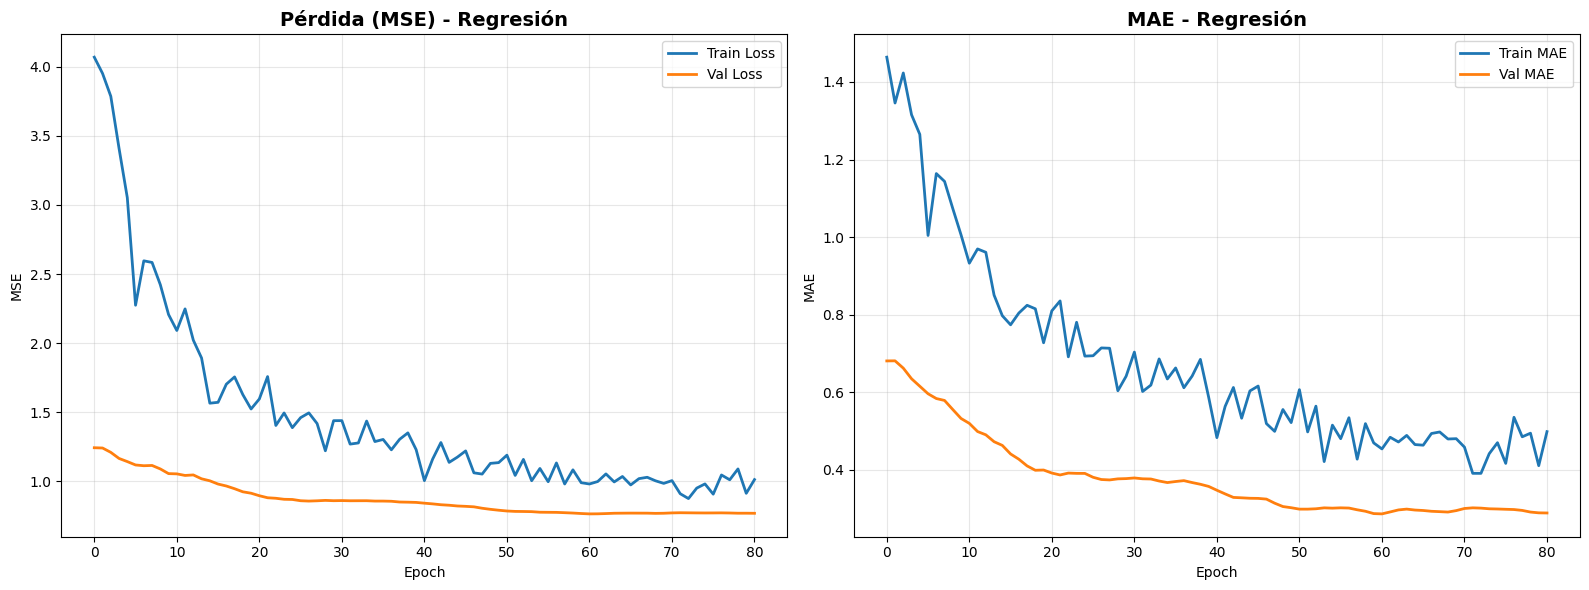

In [31]:
# Historia de regresión
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

best_history_reg = fold_histories_reg[best_fold_idx_reg]

# Loss
axes[0].plot(best_history_reg.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(best_history_reg.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Pérdida (MSE) - Regresión', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE
axes[1].plot(best_history_reg.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(best_history_reg.history['val_mae'], label='Val MAE', linewidth=2)
axes[1].set_title('MAE - Regresión', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 8. EVALUACIÓN EN TEST SET HOLDOUT (20%)

In [32]:
print(f"\n{'='*80}")
print("EVALUACIÓN FINAL EN TEST SET HOLDOUT")
print(f"{'='*80}")

# Separar test set (20% del dataset completo)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_encoded, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

X_train_reg_full, X_test_reg, y_train_reg_full, y_test_reg = train_test_split(
    X_encoded, y_regression, test_size=0.2, random_state=42
)

print(f"\nTest set: {len(X_test)} samples")
print(f"Distribución test: {Counter(y_test)}")


EVALUACIÓN FINAL EN TEST SET HOLDOUT

Test set: 21 samples
Distribución test: Counter({0.0: 17, 1.0: 4})


In [33]:
# Evaluar clasificación
scaler_clf_final = best_model_clf['scaler']
X_test_scaled = scaler_clf_final.transform(X_test)

y_test_pred_proba = best_model_clf['model'].predict(X_test_scaled, verbose=0).flatten()
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

print(f"\n{'-'*80}")
print("CLASIFICACIÓN - RESULTADOS EN TEST SET")
print(f"{'-'*78}")

acc_test = accuracy_score(y_test, y_test_pred)
prec_test = precision_score(y_test, y_test_pred, zero_division=0)
rec_test = recall_score(y_test, y_test_pred, zero_division=0)
f1_test = f1_score(y_test, y_test_pred, zero_division=0)
auc_test = roc_auc_score(y_test, y_test_pred_proba)

print(f"\n✓ Accuracy: {acc_test:.4f}")
print(f"✓ Precision: {prec_test:.4f}")
print(f"✓ Recall: {rec_test:.4f}")
print(f"✓ F1-Score: {f1_test:.4f}")
print(f"✓ AUC-ROC: {auc_test:.4f}")

print(f"\n{classification_report(y_test, y_test_pred, target_names=['No Burnout', 'Burnout'])}")


--------------------------------------------------------------------------------
CLASIFICACIÓN - RESULTADOS EN TEST SET
------------------------------------------------------------------------------

✓ Accuracy: 1.0000
✓ Precision: 1.0000
✓ Recall: 1.0000
✓ F1-Score: 1.0000
✓ AUC-ROC: 1.0000

              precision    recall  f1-score   support

  No Burnout       1.00      1.00      1.00        17
     Burnout       1.00      1.00      1.00         4

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



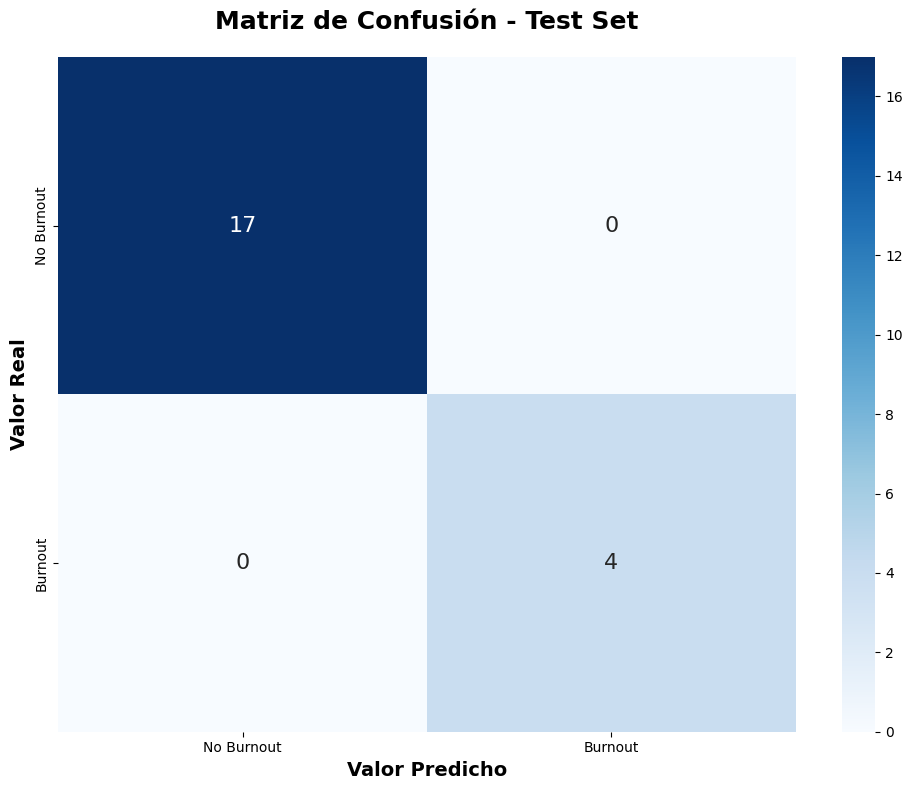

In [34]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Burnout', 'Burnout'], 
            yticklabels=['No Burnout', 'Burnout'],
            annot_kws={'size': 16})
plt.title('Matriz de Confusión - Test Set', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Valor Real', fontsize=14, fontweight='bold')
plt.xlabel('Valor Predicho', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [35]:
# Evaluar regresión
scaler_reg_final = best_model_reg['scaler']
X_test_reg_scaled = scaler_reg_final.transform(X_test_reg)

y_test_reg_pred = best_model_reg['model'].predict(X_test_reg_scaled, verbose=0).flatten()

print(f"\n{'-'*80}")
print("REGRESIÓN - RESULTADOS EN TEST SET")
print(f"{'-'*78}")

r2_test = r2_score(y_test_reg, y_test_reg_pred)
mae_test = mean_absolute_error(y_test_reg, y_test_reg_pred)
rmse_test = np.sqrt(mean_squared_error(y_test_reg, y_test_reg_pred))

print(f"\n✓ R² Score: {r2_test:.4f}")
print(f"✓ MAE: {mae_test:.4f}")
print(f"✓ RMSE: {rmse_test:.4f}")


--------------------------------------------------------------------------------
REGRESIÓN - RESULTADOS EN TEST SET
------------------------------------------------------------------------------

✓ R² Score: 0.3337
✓ MAE: 0.2858
✓ RMSE: 0.3477


TypeError: Categorical is not ordered for operation min
you can use .as_ordered() to change the Categorical to an ordered one


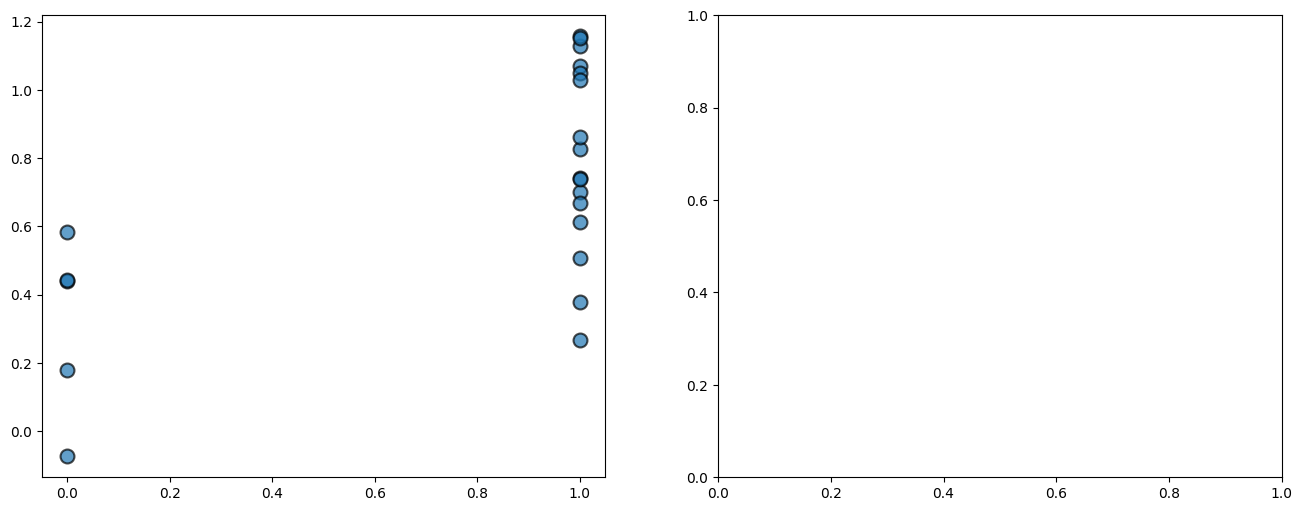

In [36]:
# Visualización regresión
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(y_test_reg, y_test_reg_pred, alpha=0.7, s=100, edgecolors='k', linewidth=1.5)
min_val = min(y_test_reg.min(), y_test_reg_pred.min())
max_val = max(y_test_reg.max(), y_test_reg_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta')
axes[0].set_xlabel('Valores Reales', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Valores Predichos', fontsize=12, fontweight='bold')
axes[0].set_title(f'Valores Reales vs Predichos (R²={r2_test:.3f})', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

residuals = y_test_reg - y_test_reg_pred
axes[1].scatter(y_test_reg_pred, residuals, alpha=0.7, s=100, edgecolors='k', linewidth=1.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2, label='Residuo = 0')
axes[1].set_xlabel('Valores Predichos', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuos', fontsize=12, fontweight='bold')
axes[1].set_title('Gráfico de Residuos', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. GUARDAR MODELOS Y ARTEFACTOS

In [ ]:
artifacts = {
    'classification_model': best_model_clf['model'],
    'regression_model': best_model_reg['model'],
    'classification_scaler': best_model_clf['scaler'],
    'regression_scaler': best_model_reg['scaler'],
    'feature_columns': feature_names,
    'fold_metrics_clf': fold_metrics_clf,
    'fold_metrics_reg': fold_metrics_reg,
    'test_metrics_clf': {
        'accuracy': acc_test,
        'precision': prec_test,
        'recall': rec_test,
        'f1': f1_test,
        'auc': auc_test
    },
    'test_metrics_reg': {
        'r2': r2_test,
        'mae': mae_test,
        'rmse': rmse_test
    }
}

# Guardar modelos en formato nativo de Keras
best_model_clf['model'].save('classification_model.h5')
best_model_reg['model'].save('regression_model.h5')
print("\n✓ Modelos guardados en formato .h5")

# Guardar artefactos (scalers y metadata)
with open('dnn_model_artifacts.pkl', 'wb') as f:
    pickle.dump({
        'classification_scaler': best_model_clf['scaler'],
        'regression_scaler': best_model_reg['scaler'],
        'feature_columns': feature_names,
        'fold_metrics_clf': fold_metrics_clf,
        'fold_metrics_reg': fold_metrics_reg,
        'test_metrics_clf': artifacts['test_metrics_clf'],
        'test_metrics_reg': artifacts['test_metrics_reg']
    }, f)

print("✓ Artefactos guardados en 'dnn_model_artifacts.pkl'")

## 10. RESUMEN COMPARATIVO: CV vs TEST

In [ ]:
print(f"\n{'='*80}")
print("RESUMEN COMPARATIVO: K-FOLD CV vs TEST SET")
print(f"{'='*80}")

print("\n📊 CLASIFICACIÓN:")
print(f"{'Métrica':<15} {'CV Mean':<15} {'CV Std':<15} {'Test':<15} {'Diferencia':<15}")
print("-" * 75)

metrics_to_compare_clf = ['accuracy', 'precision', 'recall', 'f1', 'auc']
test_values_clf = [acc_test, prec_test, rec_test, f1_test, auc_test]

for metric, test_val in zip(metrics_to_compare_clf, test_values_clf):
    cv_mean = np.mean(fold_metrics_clf[metric])
    cv_std = np.std(fold_metrics_clf[metric])
    diff = test_val - cv_mean
    print(f"{metric.upper():<15} {cv_mean:<15.4f} {cv_std:<15.4f} {test_val:<15.4f} {diff:+.4f}")

print("\n📈 REGRESIÓN:")
print(f"{'Métrica':<15} {'CV Mean':<15} {'CV Std':<15} {'Test':<15} {'Diferencia':<15}")
print("-" * 75)

metrics_to_compare_reg = ['r2', 'mae', 'rmse']
test_values_reg = [r2_test, mae_test, rmse_test]

for metric, test_val in zip(metrics_to_compare_reg, test_values_reg):
    cv_mean = np.mean(fold_metrics_reg[metric])
    cv_std = np.std(fold_metrics_reg[metric])
    diff = test_val - cv_mean
    print(f"{metric.upper():<15} {cv_mean:<15.4f} {cv_std:<15.4f} {test_val:<15.4f} {diff:+.4f}")

## 11. FUNCIÓN DE PREDICCIÓN PARA NUEVOS DATOS

In [ ]:
def predict_burnout(new_data_df, model_type='classification'):
    """
    Función para predecir burnout en nuevos datos
    
    Parameters:
    -----------
    new_data_df : pandas DataFrame
        DataFrame con las mismas columnas que el dataset original (sin targets)
    model_type : str
        'classification' o 'regression'
    
    Returns:
    --------
    predictions : numpy array
        Predicciones del modelo
    probabilities : numpy array (solo para clasificación)
        Probabilidades de pertenencia a cada clase
    """
    
    # Preprocesar igual que los datos de entrenamiento
    # (aplicar mismas transformaciones, encoding, etc.)
    
    if model_type == 'classification':
        model = best_model_clf['model']
        scaler = best_model_clf['scaler']
        
        # Asegurar que tenga las mismas columnas
        for col in feature_names:
            if col not in new_data_df.columns:
                new_data_df[col] = 0
        
        new_data_df = new_data_df[feature_names]
        
        # Escalar
        new_data_scaled = scaler.transform(new_data_df)
        
        # Predecir
        probabilities = model.predict(new_data_scaled, verbose=0).flatten()
        predictions = (probabilities > 0.5).astype(int)
        
        return predictions, probabilities
    
    elif model_type == 'regression':
        model = best_model_reg['model']
        scaler = best_model_reg['scaler']
        
        # Asegurar columnas
        for col in feature_names:
            if col not in new_data_df.columns:
                new_data_df[col] = 0
        
        new_data_df = new_data_df[feature_names]
        
        # Escalar
        new_data_scaled = scaler.transform(new_data_df)
        
        # Predecir
        predictions = model.predict(new_data_scaled, verbose=0).flatten()
        
        return predictions

In [ ]:
print(f"\n{'='*80}")
print("PROCESO COMPLETADO")
print(f"{'='*80}")
print("\n✓ Modelos DNN entrenados con K-Fold Cross Validation")
print("✓ Evaluación en test set completada")
print("✓ Artefactos guardados correctamente")
print("\nArchivos generados:")
print("  - classification_model.h5")
print("  - regression_model.h5")
print("  - dnn_model_artifacts.pkl")
print("\n📌 Usa la función predict_burnout() para hacer predicciones en nuevos datos")

## 12. EJEMPLO DE USO

In [ ]:
print(f"\n{'='*80}")
print("EJEMPLO DE USO - PREDICCIÓN EN NUEVOS DATOS")
print(f"{'='*80}")

# Tomar una muestra del test set como ejemplo
sample_data = X_test.head(3)
print(f"\nPredictiendo {len(sample_data)} casos de ejemplo...")

# Clasificación
predictions_clf, probabilities_clf = predict_burnout(sample_data, model_type='classification')

print("\n🔍 RESULTADOS DE CLASIFICACIÓN:")
for i, (pred, prob) in enumerate(zip(predictions_clf, probabilities_clf), 1):
    status = "BURNOUT" if pred == 1 else "NO BURNOUT"
    print(f"  Caso {i}: {status} (probabilidad: {prob:.2%})")

# Regresión
predictions_reg = predict_burnout(sample_data, model_type='regression')

print("\n🔍 RESULTADOS DE REGRESIÓN (Riesgo de Burnout):")
for i, pred in enumerate(predictions_reg, 1):
    print(f"  Caso {i}: {pred:.2f}")

print(f"\n{'='*80}")
print("ANÁLISIS COMPLETO FINALIZADO")
print(f"{'='*80}")